In [1]:
# Step 0. Load libraries and custom modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-12-12 02:44:18.501275: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 02:44:24.206397: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 02:44:24.211798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 02:44:34.901960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Step 1. Load the data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


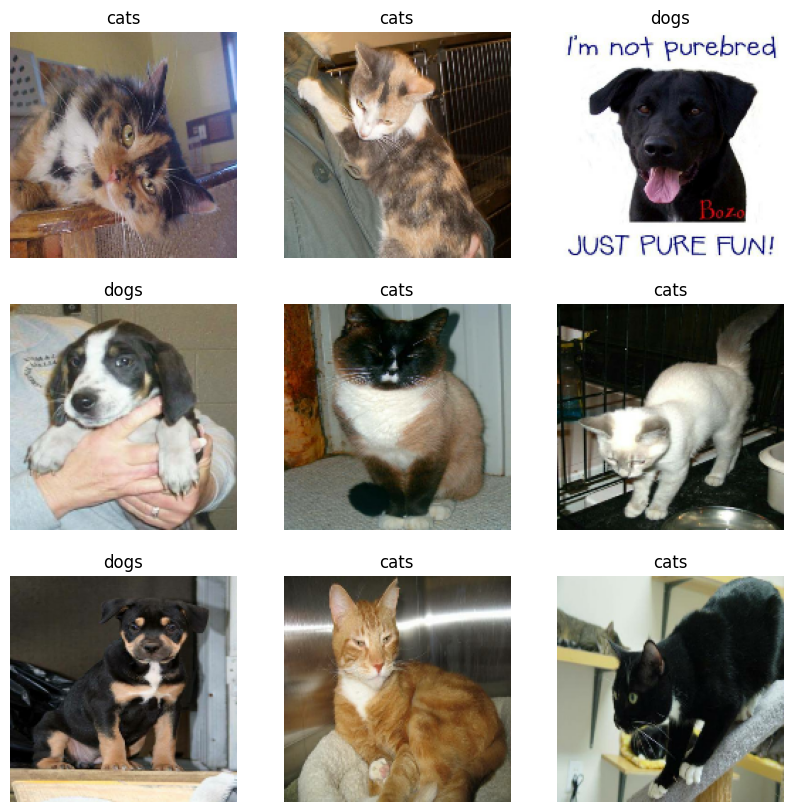

In [3]:
# Step 2. Exploratory data analysis
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(10):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [4]:
# Step 3. Deep Learning model
# 3.1 Create batches to process data
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [5]:
# 3.2 Use autotune to avoid I/O overhead
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
# 3.3 Agumentate data to provide more samples
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

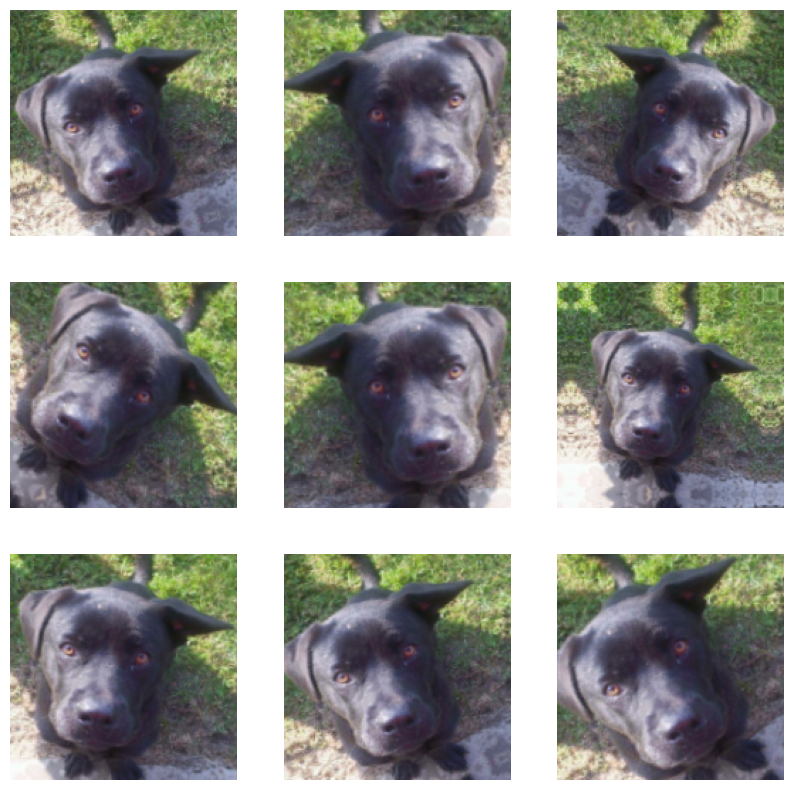

In [7]:
# 3.4 Show agumentated data
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

In [8]:
# 3.5 Import VGG pre-trained layer
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [9]:
# 3.6 Create base layer
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
# 3.7 Bring the batch as an iterable
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-12-12 02:44:59.114913: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2024-12-12 02:44:59.262372: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2024-12-12 02:44:59.287940: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2024-12-12 02:44:59.315462: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2024-12-12 02:44:59.364779: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.


(32, 5, 5, 1280)


In [11]:
# 3.8 Freeze the base model and get the summary
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [12]:
# 3.9 Set the pooling for data
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
# 3.10 Set the prediction layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [14]:
# 3.11 Create the model and show summary
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [15]:
# 3.12 Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [16]:
# 3.13 Train the model
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 13s 409ms/step - loss: 0.7177 - accuracy: 0.5458


In [17]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 33s 487ms/step - loss: 0.6851 - accuracy: 0.5950 - val_loss: 0.5055 - val_accuracy: 0.7339
Epoch 2/10
63/63 [==============================] - 29s 462ms/step - loss: 0.5459 - accuracy: 0.7100 - val_loss: 0.3707 - val_accuracy: 0.8515
Epoch 3/10
63/63 [==============================] - 28s 449ms/step - loss: 0.4356 - accuracy: 0.7810 - val_loss: 0.2824 - val_accuracy: 0.9035
Epoch 4/10
63/63 [==============================] - 28s 448ms/step - loss: 0.3764 - accuracy: 0.8195 - val_loss: 0.2369 - val_accuracy: 0.9245
Epoch 5/10
63/63 [==============================] - 29s 467ms/step - loss: 0.3331 - accuracy: 0.8450 - val_loss: 0.1998 - val_accuracy: 0.9381
Epoch 6/10
63/63 [==============================] - 28s 451ms/step - loss: 0.2971 - accuracy: 0.8605 - val_loss: 0.1766 - val_accuracy: 0.9418
Epoch 7/10
63/63 [==============================] - 29s 464ms/step - loss: 0.2775 - accuracy: 0.8800 - val_loss: 0.1615 - val_accuracy: 0.9468
Epoch 8/10